## Oppgave 1

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

In [61]:
hBar = 1.0545718e-34 # J s
m = 9.10938e-31 # kg, mass electron

N = 1000
L = 1e-22
deltaX = L/(N+1)
x = np.linspace(0, L, N+2)

q = hBar**2/(2*m * deltaX**2)
d = 2*q * np.ones(N) # Hoveddiagonalen til Hamiltonmatrisen
e = -1*q * np.ones(N-1) # Nærmeste diagonalene til hoveddiagonalen

In [62]:
# Denne funksjonen normerer bølgefunksjonen slik at integralet fra 0 til L av |psi(x)|^2 blir 1
def normalize_vectors(mat, delta_val):
    n = mat.shape[1]
    for i in range(n):
        mat[:,i] = mat[:,i] / np.sqrt(deltaX * np.sum(mat[:,i]**2))

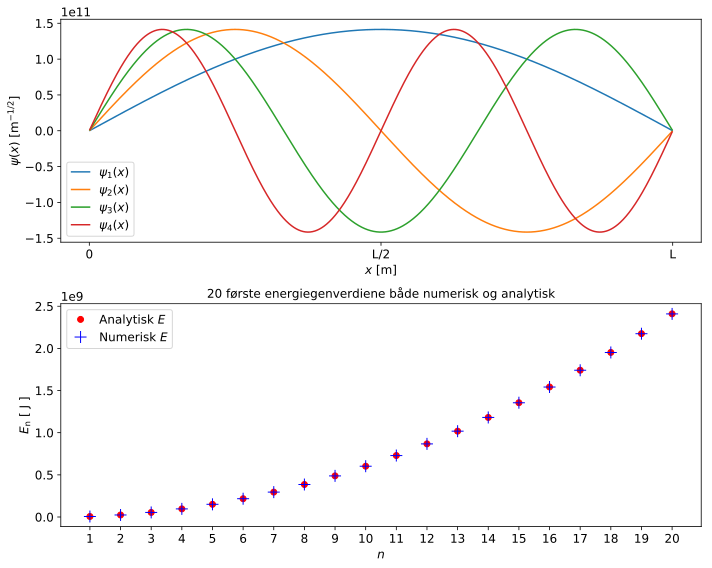

In [63]:
# Bruker scipy sin eigh_tridiagonal for å hente ut egenverdiene E, og egenvektorene psi
E, psi = eigh_tridiagonal(d, e)
# Normerer psi
normalize_vectors(psi, deltaX)

# Stiller inn ønsket parameter for figurer
fontsize = 12
newparams = {'axes.titlesize': fontsize, 'axes.labelsize': fontsize,
             'lines.linewidth': 1.5, 'lines.markersize': 12,
             'figure.figsize': (10, 8), 'ytick.labelsize': fontsize,
             'xtick.labelsize': fontsize, 'legend.fontsize': fontsize,
            'legend.handlelength': 1.5, 'figure.autolayout': True}
plt.rcParams.update(newparams)

plt.subplot(2, 1, 1)
plt.xlabel("$x$ [m]")
plt.ylabel("$\psi (x)$ [$\mathrm{m}^{-1/2}$]")
plt.plot(x[1:-1], psi[:,0], label="$\psi_1(x)$")
plt.plot(x[1:-1], psi[:,1], label="$\psi_2(x)$")
plt.plot(x[1:-1], psi[:,2], label="$\psi_3(x)$")
plt.plot(x[1:-1], psi[:,3], label="$\psi_4(x)$")
plt.xticks([0, 1/2*L, L],
          ['0', 'L/2', 'L'])
plt.legend(loc='best')

x_axis = np.arange(1, 21)
plt.subplot(2, 1, 2)
plt.title("20 første energiegenverdiene både numerisk og analytisk")
plt.xlabel("$n$")
plt.ylabel("$E_\mathrm{n}$ [ J ]")
plt.plot(x_axis, (hBar*np.pi*x_axis/L)**2/(2*m), 'r.', label="Analytisk $E$")
plt.plot(x_axis, E[:x_axis.shape[0]], 'b+', label="Numerisk $E$")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
          ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
           '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'])
plt.legend(loc='best')

plt.show()

## Oppgave 2

In [64]:
V0 = 1.5e-16
w = 50e-12 # [m]
L = 2*10*w + w
deltaX = L/(N + 1)
x = np.linspace(0, L, N + 2)

q = hBar**2/(2 * m * deltaX**2)
d = 2 * q * np.ones(N)
e = -1 * q * np.ones(N-1)

d[10*N//21+1:-10*N//21] -= V0

[-1.33964897e-16 -8.76561076e-17 -2.04279769e-17  2.35604702e-19]


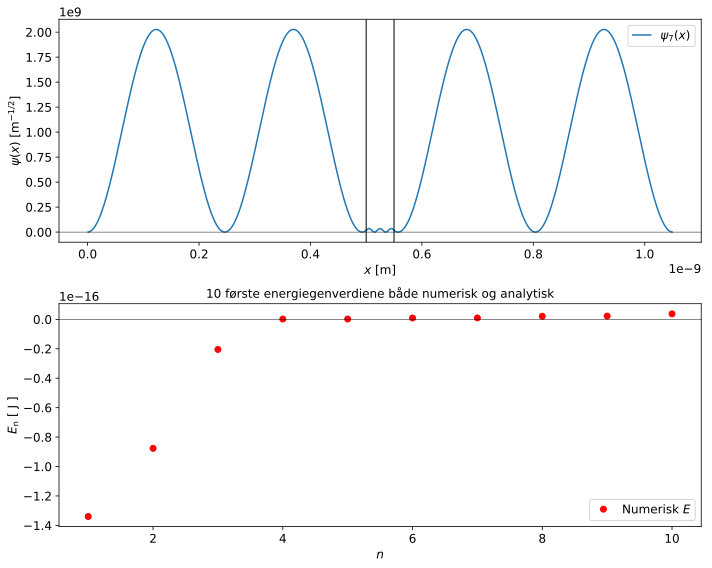

In [65]:
# Bruker scipy sin eigh_tridiagonal for å hente ut egenverdiene E, og egenvektorene psi
E, psi = eigh_tridiagonal(d, e)
# Normerer psi
normalize_vectors(psi, deltaX)
print(E[:4])

plt.subplot(2, 1, 1)
plt.xlabel("$x$ [m]")
plt.ylabel("$\psi (x)$ [$\mathrm{m}^{-1/2}$]")
#plt.plot(x[1:-1], psi[:,0], label="$\psi_1(x)$")
#plt.plot(x[1:-1], psi[:,1], label="$\psi_2(x)$")
#plt.plot(x[1:-1], psi[:,2], label="$\psi_3(x)$")
#plt.plot(x[1:-1], psi[:,3], label="$\psi_4(x)$")
#plt.plot(x[1:-1], psi[:,4], label="$\psi_5(x)$")
#plt.plot(x[1:-1], psi[:,5], label="$\psi_6(x)$")
plt.plot(x[1:-1], psi[:,6]**2, label="$\psi_7(x)$")
plt.axhline(0, linewidth=0.5, color='black')
plt.axvline((L - w)/2, linewidth=1, color='black')
plt.axvline((L + w)/2, linewidth=1, color='black')
plt.legend(loc='best')

x_axis = 1 + np.arange(10)
plt.subplot(2, 1, 2)
plt.title("10 første energiegenverdiene både numerisk og analytisk")
plt.xlabel("$n$")
plt.ylabel("$E_\mathrm{n}$ [ J ]")
plt.plot(x_axis, E[:x_axis.shape[0]], 'r.', label="Numerisk $E$")
plt.axhline(0, linewidth=0.5, color='black')
plt.legend(loc='best')

plt.show()

## Oppgave 3

In [76]:
b = w/2 # bredde mellom atomer
L = 2*10*w + 2*w + b
deltaX = L/(N + 1)
x = np.linspace(0, L, N + 2)

q = hBar**2/(2 * m * deltaX**2)
d = 2 * q * np.ones(N)
e = -1 * q * np.ones(N-1)

d[int(np.round(10*N/22.5)):int(np.round(11*N/22.5))] -= V0
d[int(np.round(11.5*N/22.5)):int(np.round(12.5*N/22.5))] -= V0

[-1.35254153e-16 -1.34967700e-16 -9.27401126e-17 -9.10671681e-17
 -3.03724969e-17 -2.37919723e-17  2.40831827e-19]


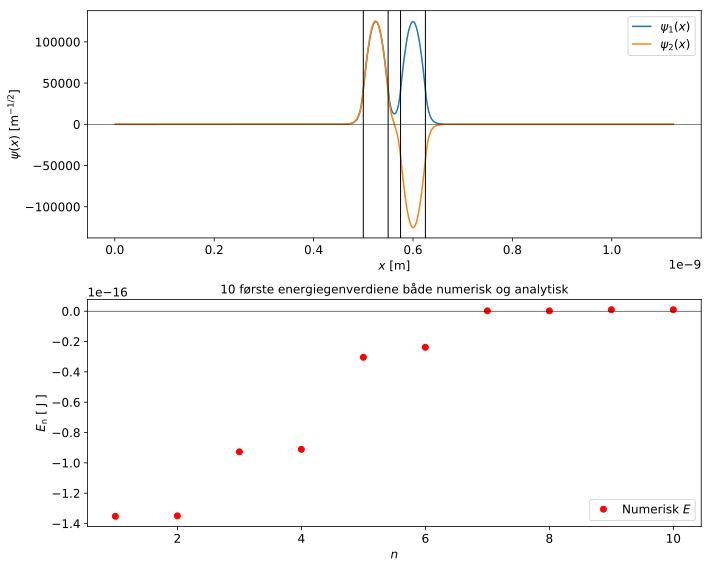

In [77]:
# Bruker scipy sin eigh_tridiagonal for å hente ut egenverdiene E, og egenvektorene psi
E, psi = eigh_tridiagonal(d, e)
# Normerer psi
normalize_vectors(psi, deltaX)
print(E[:7])

plt.subplot(2, 1, 1)
plt.xlabel("$x$ [m]")
plt.ylabel("$\psi (x)$ [$\mathrm{m}^{-1/2}$]")
plt.plot(x[1:-1], psi[:,0], label="$\psi_1(x)$")
plt.plot(x[1:-1], psi[:,1], label="$\psi_2(x)$")
#plt.plot(x[1:-1], psi[:,2], label="$\psi_3(x)$")
#plt.plot(x[1:-1], psi[:,3], label="$\psi_4(x)$")
#plt.plot(x[1:-1], psi[:,4], label="$\psi_5(x)$")
#plt.plot(x[1:-1], psi[:,5], label="$\psi_6(x)$")
#plt.plot(x[1:-4], psi[:,6]**2, label="$\psi_7(x)$")
plt.axhline(0, linewidth=0.5, color='black')
plt.axvline(L*10/22.5, linewidth=1, color='black')
plt.axvline(L*11/22.5, linewidth=1, color='black')
plt.axvline(L*11.5/22.5, linewidth=1, color='black')
plt.axvline(L*12.5/22.5, linewidth=1, color='black')
plt.legend(loc='best')

x_axis = 1 + np.arange(10)
plt.subplot(2, 1, 2)
plt.title("10 første energiegenverdiene både numerisk og analytisk")
plt.xlabel("$n$")
plt.ylabel("$E_\mathrm{n}$ [ J ]")
plt.plot(x_axis, E[:x_axis.shape[0]], 'r.', label="Numerisk $E$")
plt.axhline(0, linewidth=0.5, color='black')
plt.legend(loc='best')

plt.show()

## Oppgave 4

In [108]:

d[int(np.round(10*N/22.5)):int(np.round(11*N/22.5))] -= V0

def update_diagonal(diag, width, num_wells, barr_w, length):
    n = d.size
    delta = L / N
    if Nw % 2 and Nw > 0:
        d[int(np.round((L-w)/2)):int(np.round((L+w)/2))] -= V0
        for i in range(Nw//2):
            d[int(np.round((L+w)/2 + (i+1)*(w+b))):int(np.round((L+w)/2 + w+(i+1)*(w+b)))] -= V0
            d[int(np.round((L-w)/2 - (i+1)*(w+b))):int(np.round((L-w)/2 - w-(i+1)*(w+b)))] -= V0
    elif Nw > 0:
        for i in range(Nw//2):
            d[int(np.round(((L+b)/2 + i*(w+b))/delta)):int(np.round(((L+b)/2 + w + i*(w+b))/delta))] -= V0
            d[int(np.round(((L-b)/2 - i*(w+b))/delta)):int(np.round(((L-b)/2 - w - i*(w+b))/delta))] -= V0

In [109]:
Nw = 6
L = (2*10 + Nw)*w + (Nw-1)*b
deltaX = L/(N + 1)
x = np.linspace(0, L, N + 2)

q = hBar**2/(2 * m * deltaX**2)
d = 2 * q * np.ones(N)
e = -1 * q * np.ones(N-1)
update_diagonal(d, Nw, L, w, b, V0)

[-1.34979791e-16 -1.34773114e-16 -1.34564697e-16 -9.18573145e-17
 -9.06668914e-17 -8.94174456e-17 -2.93315926e-17]


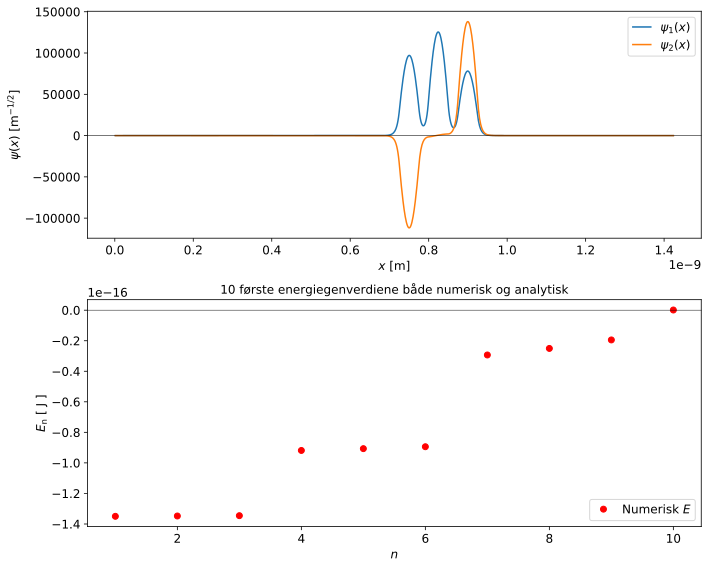

In [110]:
# Bruker scipy sin eigh_tridiagonal for å hente ut egenverdiene E, og egenvektorene psi
E, psi = eigh_tridiagonal(d, e)
# Normerer psi
normalize_vectors(psi, deltaX)
print(E[:7])

plt.subplot(2, 1, 1)
plt.xlabel("$x$ [m]")
plt.ylabel("$\psi (x)$ [$\mathrm{m}^{-1/2}$]")
plt.plot(x[1:-1], psi[:,0], label="$\psi_1(x)$")
plt.plot(x[1:-1], psi[:,1], label="$\psi_2(x)$")
#plt.plot(x[1:-1], psi[:,2], label="$\psi_3(x)$")
#plt.plot(x[1:-1], psi[:,3], label="$\psi_4(x)$")
#plt.plot(x[1:-1], psi[:,4], label="$\psi_5(x)$")
#plt.plot(x[1:-1], psi[:,5], label="$\psi_6(x)$")
#plt.plot(x[1:-4], psi[:,6]**2, label="$\psi_7(x)$")
plt.axhline(0, linewidth=0.5, color='black')
#plt.axvline(L*10/22.5, linewidth=1, color='black')
#plt.axvline(L*11/22.5, linewidth=1, color='black')
#plt.axvline(L*11.5/22.5, linewidth=1, color='black')
#plt.axvline(L*12.5/22.5, linewidth=1, color='black')
plt.legend(loc='best')

x_axis = 1 + np.arange(10)
plt.subplot(2, 1, 2)
plt.title("10 første energiegenverdiene både numerisk og analytisk")
plt.xlabel("$n$")
plt.ylabel("$E_\mathrm{n}$ [ J ]")
plt.plot(x_axis, E[:x_axis.shape[0]], 'r.', label="Numerisk $E$")
plt.axhline(0, linewidth=0.5, color='black')
plt.legend(loc='best')

plt.show()